# Homework 1 - Exploratory Data Analysis

In the lab you already saw the Boston Housing dataset in the context of predicting house prices. While this data set was already parsed for you, real data is not as organized. Hence, in this homework you are going to work with the AMES real dataset. The goal is to explore (EDA) and mold (ETL) this new dataset such that it can be fed to model in order to predict the 'SalePrice' of houses. As you might expect, the dataset both categorical and numerical features, is distribution is somewhat skewed and contains missing values. So, your task is to implement a minigful dataset parsing solution (e.g. feature extraction, distribution balancing, data augmentation, kernalization and so on) and objectively motivate your of choices.  

To accomplish this task you have at your disposal:
- The AMES dataset located in ./dataset folder.
- The dataset description file description.txt
- Trainset conveniently named train.csv
- Testset conveniently named test.csv along with its benchmark.csv targets
- An AMES dataset description paper provided with the assignment archive

While there's no single best approach to tackle this problem some general guidelines (which you may use or not) are the following:

**Dataset Cleanup General Guidelines**
- Load both train and test sets and search and eliminate duplicate (id) data.
- Look for outliers in (intuitively) relevant features (e.g. GrLivArea). Eliminate or
- Transform the features such that the outliers pose less difficulty for models (e.g. linear regression).
- Handle missing data:
   + For some missing numerical features the global average or median might be a good choice.
   + Other features may require a local the usage of a local average/median or a rolling statistic.
   + For categorical data you may want to replace NA’s with the most likely values. For example, if an NA for 'GarageType' most likely means that the house does not have a garage. So, in this case you can fill the NA’s for this feature with ”No”.
- Replace the numerical features that are actually categories (e.g. MSSubClass, MoSold).
- Encode ordered categorical features with ordered numbers (e.g. 0, 1, 2 3 ...) whenever possible

**Dataset Enginering and Augmentation Guidelines**

- You can simplify some features (e.g. 'OverallQual') by quantifying it as scores for low, average, high. For example:
```Python
train["SimplOverallQual"] =
train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # low
4 : 2, 5 : 2, 6 : 2, # average
7 : 3, 8 : 3, 9 : 3, 10 : 3 # high
})
```
- You can combine existing features that convey similar information. For example
```Python
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# House completed before sale or not
train["BoughtOffPlan"] =
train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,
"Family" : 0, "Normal" : 0, "Partial" : 1})
```
- You can generate polynomial/rbf features by using the top most relevant features in the dataset manually (see bellow) or using `sklearn` modules as we did in the lab.
```Python
# Polynomials for OverallQual
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
```  

**Visualization and Feature Selection Guidelines**
- You can observe feature correlations plots and find the top 20 most relevant features, including those that you generate.
- Data distribution plots for features may give you more insights about which are the most relevant.
- You may want to select some features based on Lasso for different values of $\alpha$.
- You may want to select all relevant or less correlated features that result from the points above.

Finally, you may want to baseline your solution using a simpler model to test the quality of your EDA/ETL such as Linear Regression. 

**Note:** Don't forget to motivate the choices you make, i.e. if you can't motivate a choice (at leat empiricaly) its most likely a wrong one.

In [ ]:
### START HERE ***
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
# load the datasets
ames_train = pd.read_csv('train.csv')
ames_test = pd.read_csv('test.csv')
ames_bm = pd.read_csv('benchmark.csv')
ames_test['SalePrice'] = ames_bm['SalePrice']
df = pd.concat([ames_train, ames_test])

### General info

In [ ]:
print(ames_train.shape)
print(ames_test.shape)
print(df.shape)

(1460, 81)
(1459, 81)
(2919, 81)


In [ ]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [ ]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [ ]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180052.854647
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,57381.565721
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,154795.084126
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,176734.841494
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,191895.744157
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [ ]:
# Helper functions

def encode_ordered_categoricals(col_name, new_col_name = None, replace_dict = None):
  drop_col = False
  if new_col_name is None:
    new_col_name = col_name
  else:
    drop_col = True
  df[new_col_name] = df[col_name].replace(replace_dict)
  if drop_col:
    df.drop([col_name], axis = 1, inplace = True)

def encode_non_ordered_categoricals(col_name):
  dummy_col = pd.get_dummies(df[col_name])  
  dummy_col_index = ames_train.columns.get_loc(col_name)

  for i in range(len(dummy_col.columns)):
    df.insert(dummy_col_index, dummy_col.columns[i], dummy_col[dummy_col.columns[i]])
    dummy_col_index += 1

  df.drop([col_name], axis = 1, inplace = True)

def plot_df(data, target = 'SalePrice', rows = 1, cols = 1):
  fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (15, 15))
  for i, feature in zip(range(len(data.keys())), data.keys()):
      print(feature)
      r, c = i % rows, i % cols
      data.plot(kind = 'scatter', x = feature, y = target, c = 'b', ax = axes[r, c])

  plt.tight_layout()

def plot_dependency(feature, target = 'SalePrice'):
  df.plot(kind = 'scatter', x = feature, y = target, c = 'b', figsize = (10, 8))
  print("Correlation: ", df[feature].corr(df[target]))

In [ ]:
# Feature encoding
# The following have been encoded through logical (e.g. quality) or through
# trial and error (e.g. numerical encoding vs dummy vars) and using external
# information (e.g. building materials).

encode_ordered_categoricals('Street',replace_dict = {np.nan : 0, 'Grvl' : 0, 'Pave' : 1})
encode_ordered_categoricals('MSZoning', replace_dict = {np.nan : 0, 'RH' : 1, 'RM' : 2, 'RL' : 3, 'FV' : 4})
encode_ordered_categoricals('LotShape', replace_dict = {'IR3' : 1, 'IR2' : 2, 'IR1' : 3, 'Reg' : 4})
encode_ordered_categoricals('LandContour', 'FlatLand', {'Lvl' : 1, 'Bnk' : 0, 'HLS' : 0, 'Low' : 0})
encode_ordered_categoricals('Utilities', replace_dict = {np.nan : 0, 'ELO' : 1, 'NoSeWa' : 2, 'NoSewr' : 3, 'AllPub' : 4})
encode_ordered_categoricals('LandSlope', replace_dict = {'Sev' : 1, 'Mod' : 2, 'Gtl' : 3})
encode_ordered_categoricals('BldgType', replace_dict = {'1Fam' : 5, '2fmCon' : 4, 'Duplex' : 3, 'TwnhsE' : 2, 'Twnhs' : 1})
encode_ordered_categoricals('HouseStyle', replace_dict = {'1Story' : 8, '1.5Fin' : 7, '1.5Unf' : 6, '2Story' : 5, '2.5Fin' : 4, '2.5Unf' : 3, 'SFoyer' : 2, 'SLvl' : 1})
encode_ordered_categoricals('RoofStyle', 'FlatRoof', {'Flat' : 1, 'Gable' : 0, 'Gambrel' : 0, 'Hip' : 0, 'Mansard' : 0, 'Shed' : 0})
encode_ordered_categoricals('Condition1', replace_dict = {'Artery' : 1, 'RRAn' : 1, 'RRNn' : 1, 'RRAe' : 1, 'RRNe' : 1, 'Feedr' : 0, 'Norm' : 0, 'PosN' : 0, 'PosA' : 0})
encode_ordered_categoricals('Condition2', replace_dict = {'Artery' : 1, 'RRAn' : 1, 'RRNn' : 1, 'RRAe' : 1, 'RRNe' : 1, 'Feedr' : 0, 'Norm' : 0, 'PosN' : 0, 'PosA' : 0})
encode_ordered_categoricals('PoolQC', 'HasPool', replace_dict = {np.nan : 0, 'NA' : 0, 'Po' : 1, 'Fa' : 1, 'TA' : 1, 'Gd' : 1, 'Ex' : 1})
encode_ordered_categoricals('Fence' , 'HasFence', replace_dict = {np.nan : 0, 'NA' : 0, 'MnWw' : 1, 'GdWo' : 1, 'MnPrv' : 1, 'GdPrv' : 1})
encode_ordered_categoricals('FireplaceQu', 'HasFireplace', replace_dict = {np.nan : 0, 'NA' : 0, 'Po' : 1, 'Fa' : 1, 'TA' : 1, 'Gd' : 1, 'Ex' : 1})
encode_ordered_categoricals('GarageCond', 'HasGarage', replace_dict = {np.nan : 0, 'Po' : 1, 'Fa' : 1, 'TA' : 1, 'Gd' : 1, 'Ex' : 1})
encode_ordered_categoricals('BsmtQual', replace_dict = {np.nan : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5})
encode_ordered_categoricals('BsmtFinType1', replace_dict = {np.nan : 0, 'NA' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ' : 6})
encode_ordered_categoricals('RoofMatl', replace_dict = {'ClyTile' : 1, 'CompShg' : 2, 'Membran' : 3, 'Metal' : 4, 'Roll' : 5, 'Tar&Grv' : 6, 'WdShake' : 7, 'WdShngl' : 8})
encode_ordered_categoricals('MasVnrType', replace_dict = {'BrkCmn' : 1, 'BrkFace' : 2, 'CBlock' : 3, 'None' : 0, 'Stone' : 4, np.nan : 0})
encode_ordered_categoricals('ExterQual', replace_dict = {np.nan : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5})
encode_ordered_categoricals('ExterCond', replace_dict = {np.nan : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5})
encode_ordered_categoricals('HeatingQC', replace_dict = {np.nan : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5})
encode_ordered_categoricals('CentralAir', 'HasAC', replace_dict = {'N' : 0, 'Y': 1})
encode_ordered_categoricals('KitchenQual', replace_dict = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5, np.nan : 0.0})
encode_ordered_categoricals('Functional', replace_dict = {np.nan : 0, 'Sal' : -4, 'Sev' : -3, 'Maj2' : -2, 'Maj1' : -1, 'Mod' : 1, 'Min2' : 2, 'Min1' : 3, 'Typ' : 4})
encode_ordered_categoricals('PavedDrive', replace_dict = {'N' : 0, 'P': 1, 'Y' : 2})
encode_ordered_categoricals('Heating', replace_dict = {'Floor' : 6, 'GasA' : 5, 'GasW' : 4, 'Grav' : 3, 'OthW' : 2, 'Wall' : 1})
encode_ordered_categoricals('Electrical', replace_dict = {'SBrkr' : 5, 'FuseA' : 4, 'FuseF' : 3, 'FuseP' : 2, 'Mix' : 1, np.nan : 0.0})

encode_ordered_categoricals('GarageArea', replace_dict = {np.nan : 0.0})
encode_ordered_categoricals('BsmtFullBath', replace_dict = {np.nan : 0.0})
encode_ordered_categoricals('BsmtHalfBath', replace_dict = {np.nan : 0.0})
encode_ordered_categoricals('BsmtFinSF1', replace_dict = {np.nan : 0.0})
encode_ordered_categoricals('BsmtFinSF2', replace_dict = {np.nan : 0.0})
encode_ordered_categoricals('BsmtUnfSF', replace_dict = {np.nan : 0.0})
encode_ordered_categoricals('TotalBsmtSF', replace_dict = {np.nan : 0.0})

In [ ]:
# create new columns, which are more representative for the real estate business
df['TotalSqft'] = df['TotalBsmtSF'] + df['GarageArea'] + df['GrLivArea']
df['TotalSqft'] = df['TotalSqft'].fillna(df['TotalSqft'].median())

df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

df['BaseLivArea'] = df['TotalBsmtSF'] - df['BsmtUnfSF']

baths = [col for col in df.columns if 'Bath' in col]
df['TotalBaths'] = df[baths].sum(axis = 1)

df['TotPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

In [ ]:
# encode categorical features
encode_non_ordered_categoricals('Neighborhood')
encode_non_ordered_categoricals('Foundation')
encode_non_ordered_categoricals('SaleType')

df = df[(df.SaleCondition != 'Abnorml')]
df = df[(df.SaleCondition != 'Family')]

encode_non_ordered_categoricals('SaleCondition')

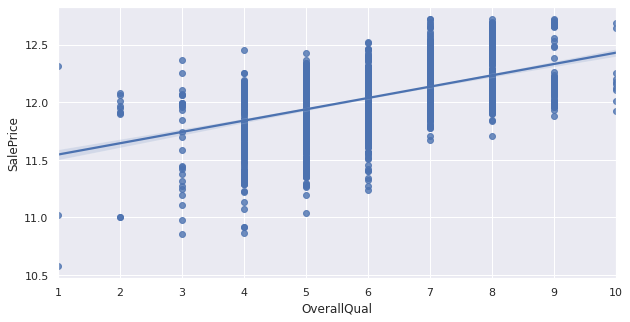

In [ ]:
fig, ax = plt.subplots( figsize =  (10, 5))
sns.regplot(x = "OverallQual", y = "SalePrice", data = df, ax = ax) 

In [ ]:
# Some outlier removal, according to graphs
df = df[df['LotArea'] < 55000]
df = df[df['GrLivArea'] < 3000]
df = df[df['TotalBsmtSF'] < 2500]
df = df[df['GarageArea'] < 1200]
df = df[(df['SalePrice'] < df['SalePrice'].mean() + 3 * df['SalePrice'].std())]
df = df[(df['BaseLivArea'] < 1800)]

In [ ]:
# check if any column has more than 1000 NaN values
[print(col) for col in ames_train.columns if ames_train[col].isna().sum() >= 1000]
[print(col) for col in ames_test.columns if ames_test[col].isna().sum() >= 1000]

# drop 'Alley' and 'MiscFeature', not influencing the result much
df = df.drop(['Alley', 'MiscFeature'], axis = 1)

Alley
PoolQC
Fence
MiscFeature
Alley
PoolQC
Fence
MiscFeature


In [ ]:
# Too few observations for 'C (all)'
print(df['MSZoning'].unique())
print(df['MSZoning'].value_counts())
df = df[df['MSZoning'] != 'C (all)']

[3 2 'C (all)' 4 1 0]
3          2008
2           406
4           129
1            19
C (all)      14
0             2
Name: MSZoning, dtype: int64


In [ ]:
# check if any column has only one value
[print(col) for col in df.columns if len(df[col].unique()) == 1]
# Check for duplicate data
print(df.duplicated().sum())

0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


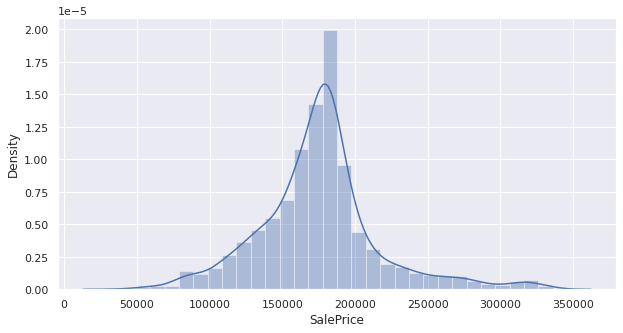

In [ ]:
fig, ax = plt.subplots(figsize =  (10, 5))
sns.distplot(df.SalePrice, bins = 30, kde = True, ax = ax)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


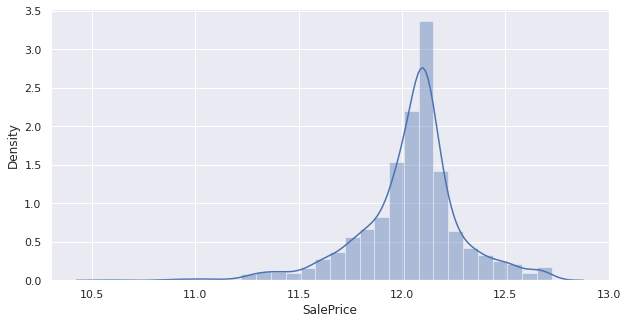

In [ ]:
# price a bit right skewed, try to log it, although not much of a difference in the end result
df['SalePrice'] = np.log1p(df['SalePrice'])
fig, ax = plt.subplots(figsize =  (10, 5))
sns.distplot(df.SalePrice, bins = 30, kde = True, ax = ax)

Most important features:  ['TotalSqft', 'GrLivArea', 'OverallQual', 'GarageCars', 'GarageArea', 'TotalBaths', 'TotRmsAbvGrd', 'FullBath', 'KitchenQual']


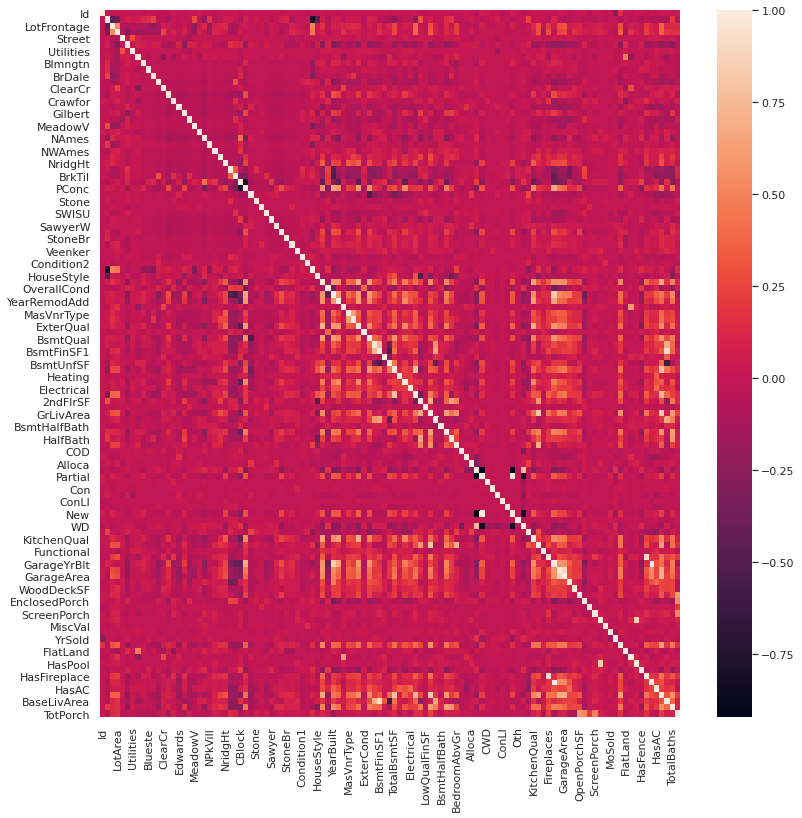

In [ ]:
sns.set(rc = {'figure.figsize' : (13, 13)})
corr = df.round(3).corr()
sns.heatmap(corr)

corr_y = corr['SalePrice']
irrelev_features = corr_y[corr_y < 0.0]
irrelev_cols = [col for col, val in irrelev_features.iteritems()]
df.drop(irrelev_cols, axis = 1, inplace = True)

relev_features = corr_y.sort_values(ascending = False)[1:10]
relev_cols = [col for col, val in relev_features.iteritems()]
print('Most important features: ', relev_cols)

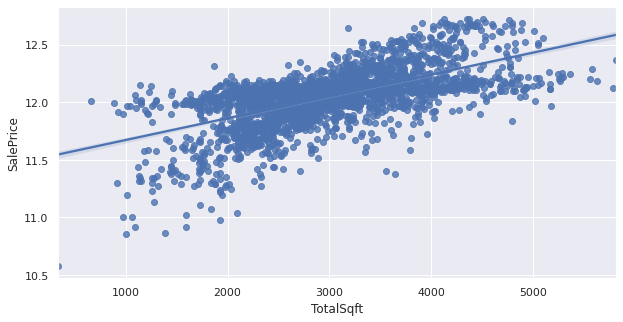

In [ ]:
fig, ax = plt.subplots( figsize =  (10, 5))
sns.regplot(x = "TotalSqft", y = "SalePrice", data = df, ax = ax) 

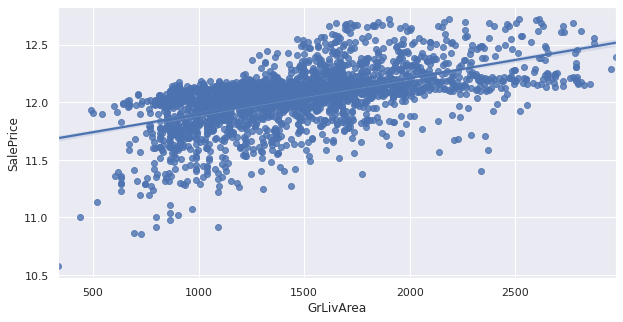

In [ ]:
fig, ax = plt.subplots( figsize =  (10, 5))
sns.regplot(x = "GrLivArea", y = "SalePrice", data = df, ax = ax) 

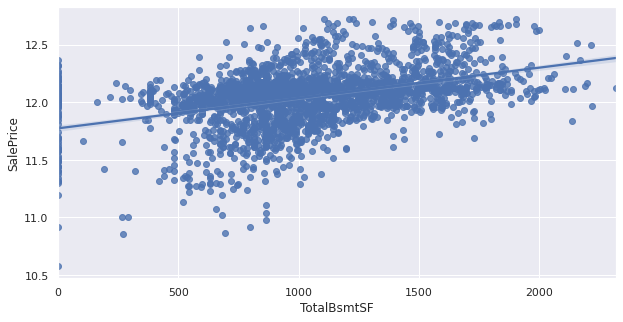

In [ ]:
fig, ax = plt.subplots( figsize =  (10, 5))
sns.regplot(x = "TotalBsmtSF", y = "SalePrice", data = df, ax = ax)

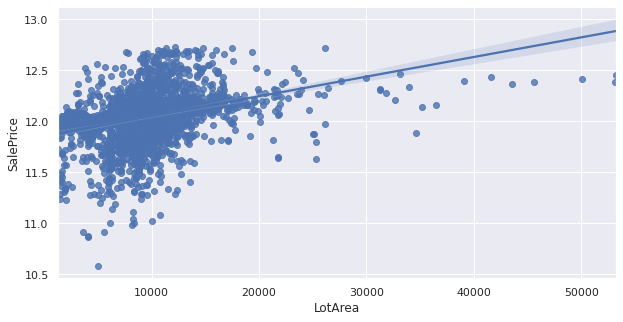

In [ ]:
fig, ax = plt.subplots( figsize =  (10, 5))
sns.regplot(x = "LotArea", y = "SalePrice", data = df, ax = ax)

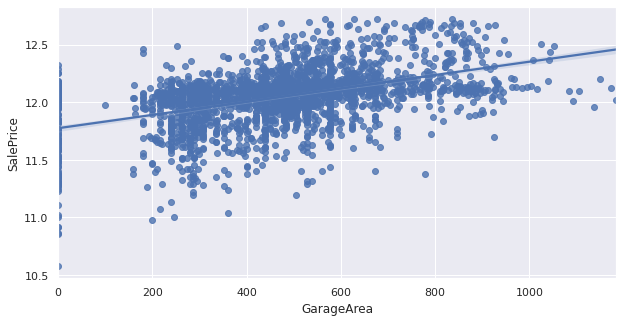

In [ ]:
fig, ax = plt.subplots( figsize =  (10, 5))
sns.regplot(x = "GarageArea", y = "SalePrice", data = df, ax = ax)

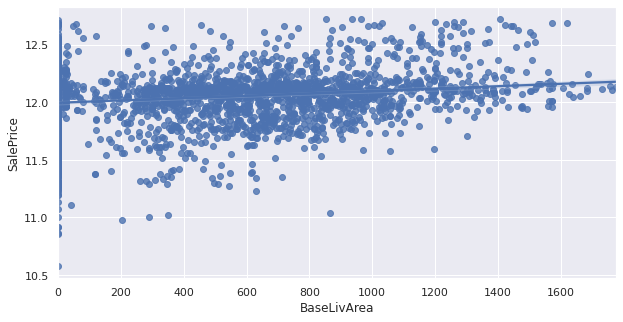

In [ ]:
fig, ax = plt.subplots( figsize =  (10, 5))
sns.regplot(x = "BaseLivArea", y = "SalePrice", data = df, ax = ax)

In [ ]:
# drop columns not really found to be contributing to the final result
df.drop(['BsmtCond', 'BsmtExposure', 'GarageType', 'GarageFinish', 'BsmtFinType2', 
         'GarageQual', 'Exterior1st', 'Exterior2nd', 'FullBath', 'HalfBath',
         'BsmtFullBath', 'GarageCars', 'OpenPorchSF', '3SsnPorch', 
         'ScreenPorch', 'LotConfig', 'GarageYrBlt', 'MoSold'], axis = 1, inplace = True)

In [ ]:
# Prediction
X = df.drop(['SalePrice'], axis = 1).to_numpy()
y =  df['SalePrice'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

ss = StandardScaler()
ss.fit(x_train)
x_train_s = ss.transform(x_train)
x_test_s = ss.transform(x_test)

lr = LinearRegression(n_jobs = -1)
lr.fit(x_train_s, y_train)
print('Linear Regression R2:', lr.score(x_test_s, y_test))

lasso = LassoCV(cv = 5, n_jobs = -1)
lasso.fit(x_train_s, y_train)
print('Lasso R2:', lasso.score(x_test_s, y_test))


Linear Regression R2: 0.4831400148035049
Lasso R2: 0.4958853452315526
